# Data Transformations2

**Introduction:**
Using the data gathered from Taarifa and the Tanzanian Ministry of Water, can we predict which pumps are functional, which need some repairs, and which don't work at all? Predicting one of these three classes based and a smart understanding of which waterpoints will fail, can improve the maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

This is also an intermediate-level competition by [DataDriven][1]! All code & support scripts are in [Github Repo][2]

[1]: https://www.drivendata.org/competitions/7/ "Link to Competetion Page"
[2]: https://github.com/msampathkumar/datadriven_pumpit "User Code"

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA

from scripts.sam_variance_check import get_low_variance_columns
from scripts.tools import check_metric, data_transformations
from scripts.tools import df_check_stats, game, sam_pickle_save, sam_pickle_load

%matplotlib inline


np.set_printoptions(precision=5)
np.random.seed(69572)
plt.style.use('ggplot')
sns.set(color_codes=True)

crazy_list = ()

In [2]:
for each in dir():
    if each not in crazy_list:
        del each

# Loading data from previos
X, y, TEST_X = sam_pickle_load(prefix="tmp/Iteration2_final_")
df_check_stats(X, y, TEST_X)

LOAD PREFIX USED:  tmp/Iteration2_final_
Data Frame Shape: (59400, 25) TotColumns: 25 ObjectCols: 0
Numpy Array Size: 59400
Data Frame Shape: (14850, 25) TotColumns: 25 ObjectCols: 0


In [14]:
from sklearn import svm

# from sklearn.datasets import samples_generator
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, chi2
from sklearn.pipeline import Pipeline

In [15]:
X = X.head(1000)
y = y[:1000]

# ANOVA SVM-C
anova_filter = SelectKBest(chi2, k=5)
clf = svm.SVC(kernel='linear')
anova_svm = Pipeline([('anova', anova_filter), ('svc', clf)])
# You can set the parameters using the names issued
# For instance, fit using a k of 10 in the SelectKBest
# and a parameter 'C' of the svm
anova_svm.set_params(anova__k=20, svc__C=.1).fit(X, y)
                                             

prediction = anova_svm.predict(X)
anova_svm.score(X, y)                        

# getting the selected features chosen by anova_filter
anova_svm.named_steps['anova'].get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True, False,  True, False,  True,
        True,  True,  True,  True, False,  True,  True], dtype=bool)

In [24]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy='most_frequent',random_state=0)
clf.fit(X, y)
print (each, clf.score(X, y))

In [20]:
X.columns, len(X.columns), X.columns[anova_svm.named_steps['anova'].get_support()], len(X.columns[anova_svm.named_steps['anova'].get_support()])

(Index(['date_recorded', 'funder', 'gps_height', 'installer', 'longitude',
        'latitude', 'basin', 'region', 'population', 'public_meeting',
        'scheme_management', 'permit', 'construction_year', 'extraction_type',
        'management', 'payment_type', 'quality_group', 'quantity',
        'quantity_group', 'source', 'waterpoint_type', 'date_recorded_month',
        'Area', 'Population02', 'Population12'],
       dtype='object'),
 25,
 Index(['date_recorded', 'funder', 'gps_height', 'installer', 'longitude',
        'latitude', 'basin', 'region', 'population', 'scheme_management',
        'construction_year', 'extraction_type', 'payment_type', 'quantity',
        'quantity_group', 'source', 'waterpoint_type', 'date_recorded_month',
        'Population02', 'Population12'],
       dtype='object'),
 20)

In [49]:
# Test-Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42, stratify=y)

In [50]:
# RF
clf = game(X_train, X_test, y_train, y_test, algo='rf')

------------------------------------------------
AC Score: 0.799797979798 F1 Score: 0.805134443816


In [51]:
# GBT
gbt_clf = game(X_train, X_test, y_train, y_test, algo='gb')

------------------------------------------------
AC Score: 0.750976430976 F1 Score: 0.775322264654


In [52]:
# KNN
knn_clf = game(X_train, X_test, y_train, y_test, algo='knn')

------------------------------------------------
AC Score: 0.705454545455 F1 Score: 0.712548891875


## Variance Threshold

In [53]:
# Variance Threshold
X, removed_features, ranking_variance_thresholds = get_low_variance_columns(
    dframe=X, threshold=(0.85 * (1 - 0.85)), autoremove=True)
TEST_X.drop(removed_features, axis=1, inplace=True)

Finding low-variance features.
Found 1 low-variance columns.
                
Removing low-variance features.
Reassembling the dataframe (with low-variance features removed).
Succesfully removed low-variance columns.


In [54]:
print(removed_features)

['public_meeting']


In [55]:
sam_pickle_save(X, y, TEST_X, prefix="tmp/Iteration2_vt_")

SAVE PREFIX USED:  tmp/Iteration2_vt_


In [56]:
for each in dir():
    if each not in crazy_list:
        del each

X, y, TEST_X = sam_pickle_load(prefix='tmp/Iteration2_vt_')

df_check_stats(X, y, TEST_X)

LOAD PREFIX USED:  tmp/Iteration2_vt_
Data Frame Shape: (59400, 24) TotColumns: 24 ObjectCols: 0
Numpy Array Size: 59400
Data Frame Shape: (14850, 24) TotColumns: 24 ObjectCols: 0


In [57]:
# Test Train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42, stratify=y)

In [58]:
# RF
clf = game(X_train, X_test, y_train, y_test, algo='rf', )

------------------------------------------------
AC Score: 0.798922558923 F1 Score: 0.804858831616


In [59]:
# GBT
clf = game(X_train, X_test, y_train, y_test, algo='gb', )

------------------------------------------------
AC Score: 0.752188552189 F1 Score: 0.775768094424


Effects of Variance Threshold

* For RF, score reduce from .799 to 798 
* For GBT, score improved from .7509 to .7521

## K Best Selection

In [61]:
for each in dir():
    if each not in crazy_list:
        del each

X, y, TEST_X = sam_pickle_load(prefix='tmp/Iteration2_vt_')

df_check_stats(X)

TEST_X.head()

LOAD PREFIX USED:  tmp/Iteration2_vt_
Data Frame Shape: (59400, 24) TotColumns: 24 ObjectCols: 0


,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,population,scheme_management,...,payment_type,quality_group,quantity,quantity_group,source,waterpoint_type,date_recorded_month,Area,Population02,Population12
id,,,,,,,,,,,,,,,,,,,,,
50785,292,175,2049,207,35933,45025,0,8,319,4,...,2,2,3,3,5,6,1,14,4,7
51630,292,250,1622,219,44888,53443,5,0,299,8,...,2,2,2,2,8,1,1,12,9,10
17168,289,569,1620,597,31619,35757,0,18,477,8,...,2,2,2,2,5,6,1,15,5,5
45559,279,222,319,242,57636,9125,7,7,250,8,...,6,2,0,0,7,6,0,18,1,0
49871,343,73,1313,83,34320,1346,7,16,60,10,...,1,2,1,1,8,1,2,17,6,6


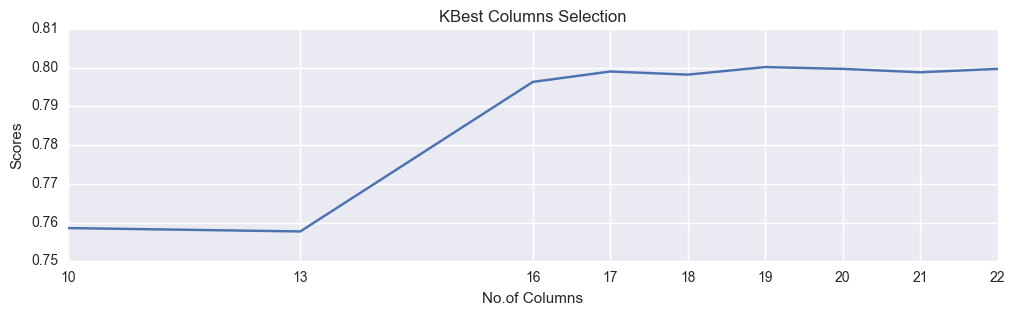

In [62]:
# Logs from above are organised nicely here

data = '''
============================================================ 10
LOAD PREFIX USED:  tmp/Iteration2_vt_
------------------------------------------------
AC Score: 0.758585858586 F1 Score: 0.764190112954
============================================================ 13
LOAD PREFIX USED:  tmp/Iteration2_vt_
------------------------------------------------
AC Score: 0.75771043771 F1 Score: 0.762772800662
============================================================ 16
LOAD PREFIX USED:  tmp/Iteration2_vt_
------------------------------------------------
AC Score: 0.796296296296 F1 Score: 0.802379385314
============================================================ 17
LOAD PREFIX USED:  tmp/Iteration2_vt_
------------------------------------------------
AC Score: 0.79898989899 F1 Score: 0.804890015569
============================================================ 18
LOAD PREFIX USED:  tmp/Iteration2_vt_
------------------------------------------------
AC Score: 0.798181818182 F1 Score: 0.803884003093
============================================================ 19
LOAD PREFIX USED:  tmp/Iteration2_vt_
------------------------------------------------
AC Score: 0.800134680135 F1 Score: 0.805811215543
============================================================ 20
LOAD PREFIX USED:  tmp/Iteration2_vt_
------------------------------------------------
AC Score: 0.799663299663 F1 Score: 0.805597807791
============================================================ 21
LOAD PREFIX USED:  tmp/Iteration2_vt_
------------------------------------------------
AC Score: 0.798787878788 F1 Score: 0.804484395135
============================================================ 22
LOAD PREFIX USED:  tmp/Iteration2_vt_
------------------------------------------------
AC Score: 0.799663299663 F1 Score: 0.805620208961

'''.strip()

data_k_selections = []
data_k_ac_scores = []
data_k_f1_scores = []

for line in data.strip().splitlines():
    if line.startswith('===='):
        data_k_selections.append(int(line.split()[-1]))
    if line.startswith('AC Score'):
        line = line.split()
        data_k_ac_scores.append(float(line[2]))
        data_k_f1_scores.append(float(line[-1]))

plt.figure(figsize=(12, 3))
plt.plot(data_k_selections, data_k_ac_scores)
plt.xticks(data_k_selections)
plt.xlabel('No.of Columns')
plt.ylabel('Scores')
plt.title('KBest Columns Selection')

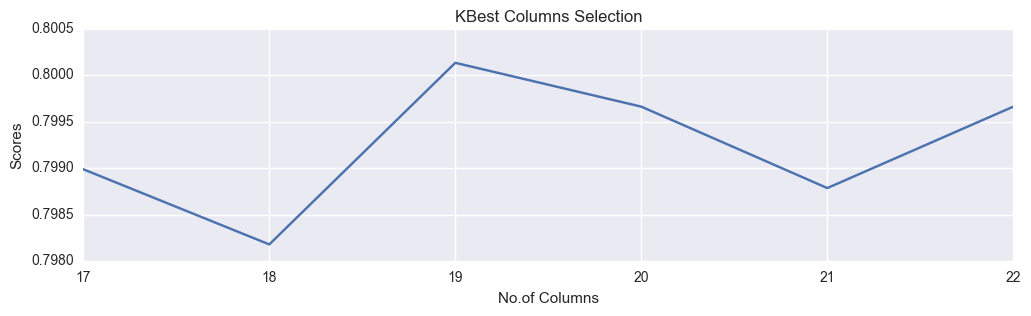

In [28]:
show_tick_from_point = 3 # select the tick index from above graph

plt.figure(figsize=(12, 3))
plt.plot(data_k_selections[show_tick_from_point:], data_k_ac_scores[show_tick_from_point:])
plt.xticks(data_k_selections[show_tick_from_point:])
plt.xlabel('No.of Columns')
plt.ylabel('Scores')
plt.title('KBest Columns Selection')

In [80]:
for each in dir():
    if each not in crazy_list:
        del each


X, y, TEST_X = sam_pickle_load(prefix='tmp/Iteration2_vt_')

df_check_stats(X)

TEST_X.head()

LOAD PREFIX USED:  tmp/Iteration2_vt_
Data Frame Shape: (59400, 24) TotColumns: 24 ObjectCols: 0


,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,population,scheme_management,...,payment_type,quality_group,quantity,quantity_group,source,waterpoint_type,date_recorded_month,Area,Population02,Population12
id,,,,,,,,,,,,,,,,,,,,,
50785,292,175,2049,207,35933,45025,0,8,319,4,...,2,2,3,3,5,6,1,14,4,7
51630,292,250,1622,219,44888,53443,5,0,299,8,...,2,2,2,2,8,1,1,12,9,10
17168,289,569,1620,597,31619,35757,0,18,477,8,...,2,2,2,2,5,6,1,15,5,5
45559,279,222,319,242,57636,9125,7,7,250,8,...,6,2,0,0,7,6,0,18,1,0
49871,343,73,1313,83,34320,1346,7,16,60,10,...,1,2,1,1,8,1,2,17,6,6


In [83]:
fit = SelectKBest(score_func=chi2, k=kbest_cols).fit(X, y)
cols_names = X.columns
kbest_selected_cols =  [_ for _ in cols_names[:kbest_cols]]

test_ids = TEST_X.index

# transformation
X = pd.DataFrame(fit.transform(X))
TEST_X = pd.DataFrame(fit.transform(TEST_X), index=test_ids)

In [84]:
# Test-Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42, stratify=y)

In [85]:
# RF
clf = game(X_train, X_test, y_train, y_test, algo='rf')

------------------------------------------------
AC Score: 0.800134680135 F1 Score: 0.805811215543


In [86]:
# GBT
clf = game(X_train, X_test, y_train, y_test, algo='gb')

------------------------------------------------
AC Score: 0.751313131313 F1 Score: 0.774869584539


In [87]:
sam_pickle_save(X, y, TEST_X, prefix='tmp/Iteration2_vt_kb_')

SAVE PREFIX USED:  tmp/Iteration2_vt_kb_


## PCA

In [24]:
for each in dir():
    if each not in crazy_list:
        del each

X, y, TEST_X = sam_pickle_load(prefix='tmp/Iteration2_vt_kb_')
df_check_stats(X, y, TEST_X)

LOAD PREFIX USED:  tmp/Iteration2_vt_kb_
Data Frame Shape: (59400, 19) TotColumns: 19 ObjectCols: 0
Numpy Array Size: 59400
Data Frame Shape: (14850, 19) TotColumns: 19 ObjectCols: 0


In [26]:
# PCA
from sklearn.decomposition import PCA

# defaults
pca = PCA(n_components=15)
fit = pca.fit(X)

X = fit.transform(X)

In [27]:
# benchmark
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42, stratify=y)
clf = game(X_train, X_test, y_train, y_test, algo='rf')

------------------------------------------------
AC Score: 0.760067340067 F1 Score: 0.766591022239


In [28]:
clf = game(X_train, X_test, y_train, y_test, algo='gb')

------------------------------------------------
AC Score: 0.685858585859 F1 Score: 0.712095898786


In [29]:
df_check_stats(X, y, TEST_X)

Numpy Array Size: 59400
Numpy Array Size: 59400
Data Frame Shape: (14850, 19) TotColumns: 19 ObjectCols: 0


Clearly we can see that rather than improved the performance has reduce compartively to what happened in VT or KBest stages. So we are not saving the data.

# Analysis

In [30]:
# Random Forest
rf_data = '''
AC Score: 0.799797979798 F1 Score: 0.805134443816 # benchmark
AC Score: 0.798922558923 F1 Score: 0.804858831616 # vt
AC Score: 0.800134680135 F1 Score: 0.805811215543 # k best
AC Score: 0.760067340067 F1 Score: 0.766591022239 # p c a
'''.strip().splitlines()

# GBT
gb_data = '''
AC Score: 0.750976430976 F1 Score: 0.775322264654 # benchmark
AC Score: 0.752188552189 F1 Score: 0.775768094424 # vt
AC Score: 0.751313131313 F1 Score: 0.774869584539 # k best
AC Score: 0.685858585859 F1 Score: 0.712095898786 # p c a
'''.strip().splitlines()

In [31]:
def log_parser(log_data):
    ac_scores = []
    rf_scores = []
    for each in log_data:
        each = each.split()
        ac_scores.append(each[2])
        rf_scores.append(each[5])
    return ac_scores, rf_scores

rf_ac_scores, rf_f1_scores = log_parser(rf_data)
gb_ac_scores, gb_f1_scores = log_parser(gb_data)

In [32]:
names = '''
Benchmark
VarThresh
K-BestSel
P.C.A
'''.strip().split()

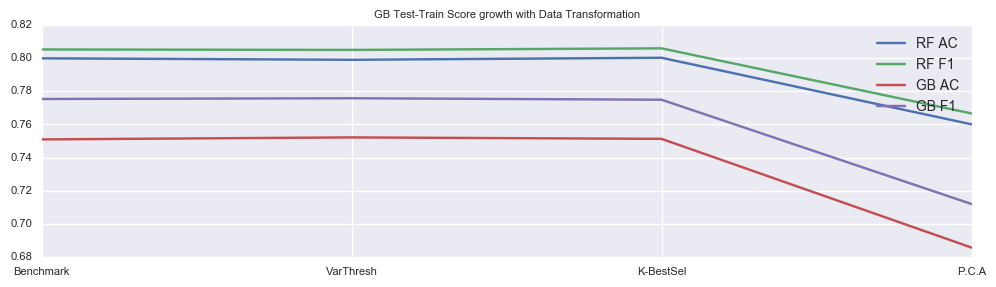

In [33]:
plot_size = (12, 3)

plt.figure(figsize=plot_size)
plt.plot(range(len(names)), rf_ac_scores)
plt.plot(range(len(names)), rf_f1_scores)
plt.plot(range(len(names)), gb_ac_scores)
plt.plot(range(len(names)), gb_f1_scores)
plt.title('GB Test-Train Score growth with Data Transformation', fontsize=8)
plt.yticks(fontsize=8)
plt.xticks(np.arange(len(names)) + .0004, names, fontsize=8)
plt.legend(['RF AC', 'RF F1', 'GB AC', 'GB F1'])

In [34]:
TEST_X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,292,175,2049,207,35933,45025,8,319,4,14,9,2,2,3,3,5,6,4,7
1,292,250,1622,219,44888,53443,0,299,8,11,3,2,2,2,2,8,1,9,10
2,289,569,1620,597,31619,35757,18,477,8,13,9,2,2,2,2,5,6,5,5
3,279,222,319,242,57636,9125,7,250,8,7,9,6,2,0,0,7,6,1,0
4,343,73,1313,83,34320,1346,16,60,10,11,3,1,2,1,1,8,1,6,6
